## Creating a function that changes the resolution of any grid and then visualizes it.

In [1]:
import geopandas as gpd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
#import os

In [2]:
gdf = gpd.read_file(r'C:\Users\Ankit\Documents\Vedanshi\ML-hands-on\course_work\shp_rohit\alknanda.shp')
gdf = gdf.to_crs(4326)
gdf=gdf.to_crs(4326)

In [3]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

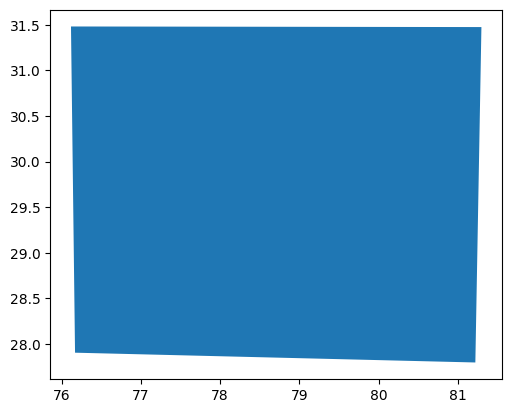

In [4]:
gdf.plot()

In [5]:
bound_box=gdf.total_bounds
minx,miny,maxx,maxy=bound_box

In [6]:
from shapely.geometry import box
# Create a rectangle from these coordinates using shapely's box function
rectangle = gpd.GeoSeries([box(minx, miny, maxx, maxy)], crs='epsg:4326')
# Print the rectangle coordinates
print(f"Bounding Box Coordinates: {bound_box}")
print(f"Rectangle Geometry: {rectangle}")

Bounding Box Coordinates: [76.11703155 27.79598912 81.29884383 31.48307196]
Rectangle Geometry: 0    POLYGON ((81.29884 27.79599, 81.29884 31.48307...
dtype: geometry


<Axes: >

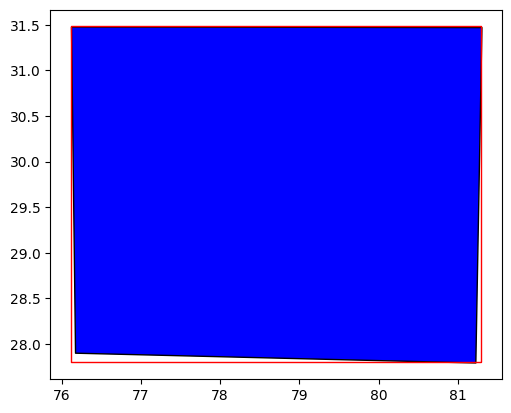

In [7]:
ax = gdf.plot(color='blue', edgecolor='k')
rectangle.plot(ax=ax, color='none', edgecolor='red')

In [8]:
polygon=gdf.geometry[0]
coordinates = list(polygon.exterior.coords)
coordinates.remove(coordinates[4])
coordinates

[(81.29884382960824, 31.476528380639817),
 (81.22216592787854, 27.795989119659698),
 (76.16815971828309, 27.903402904818343),
 (76.1170315460337, 31.483071960344766)]

In [9]:
#changing the parameters to improve the fit of the box.
minx=76.16815971828309
miny=27.803402904818343
maxx=81.24216592787854

Bounding Box Coordinates: [76.11703155 27.79598912 81.29884383 31.48307196]
Rectangle Geometry: 0    POLYGON ((81.24217 27.80340, 81.24217 31.48307...
dtype: geometry


<Axes: >

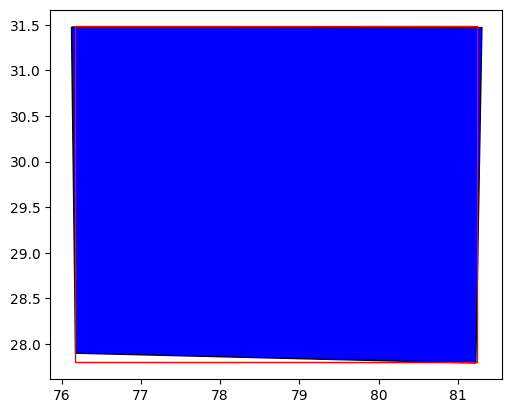

In [10]:
from shapely.geometry import box
# Create a rectangle from these coordinates using shapely's box function
rectangle = gpd.GeoSeries([box(minx, miny, maxx, maxy)], crs='epsg:4326')
# Print the rectangle coordinates
print(f"Bounding Box Coordinates: {bound_box}")
print(f"Rectangle Geometry: {rectangle}")
ax = gdf.plot(color='blue', edgecolor='k')
rectangle.plot(ax=ax, color='none', edgecolor='red')

In [11]:
# function to calculate grid parameters
def calculate_grid_parameters(coord):
    d = np.diff(coord)[0] / 2
    cell_boundaries = np.concatenate([[coord[0] - d], coord + d])
    return cell_boundaries

In [12]:
# function to create grid cell taking arguments from x_values and y_values
def initialize_and_populate_grid(x_values, y_values):
    ngrid_cell = len(x_values) * len(y_values)
    grid_cell = [{} for _ in range(ngrid_cell)]
    
    dy = y_values[1] - y_values[0]
    k = 0
    
    loncell = calculate_grid_parameters(x_values)
    latcell = calculate_grid_parameters(y_values)
    
    for i, lon in enumerate(x_values):
        for j, lat in enumerate(y_values):
            x_coords = [round(loncell[i], 2), round(loncell[i], 2), round(loncell[i+1], 2), round(loncell[i+1], 2), round(loncell[i], 2)]
            y_coords = [round(latcell[j], 2), round(latcell[j+1], 2), round(latcell[j+1], 2), round(latcell[j], 2), round(latcell[j], 2)] if dy > 0 else \
                       [round(latcell[j+1], 2), round(latcell[j], 2), round(latcell[j], 2), round(latcell[j+1], 2), round(latcell[j+1], 2)]
            
            grid_cell[k] = {'X':x_coords,'Y':y_coords,'Xc': round(lon, 2), 'Yc': round(lat, 2)}
            k += 1
    return grid_cell

In [13]:
def res_change(minx, miny, maxx, maxy, input_res, output_res):
    '''returns the x and y coordinates of centroids for the input and output resolution grid, in the order of 
    x,y being the x and y coordinates of the centroids of the grid cells for the input resolution grid and x_out,y_out being the x and y coordinates of the centroids of the grid cells for the output resolution grid.
    the function also returns the grid for output resolution.'''
    number_x_inp=maxx-minx//input_res
    number_y_inp=maxy-miny//input_res
    number_y_out=maxy-miny//output_res
    number_x_inp=maxx-minx//output_res

    if ((maxx-minx)*(maxy-miny)!=((input_res/output_res)**2)*(maxx-minx)*(maxy-miny)):
        print("The resolution change is not exact.")
        #back_calc((minx, miny, maxx, maxy))
        
    else:
        print("The resolution change is exact.")

    # Generate x-values for the input resolution grid
    x_values = []
    current_x = minx
    while current_x < maxx:
        x_values.append(current_x)
        current_x += input_res
    
    # Generate y-values for the input resolution grid
    y_values = []
    current_y = miny
    while current_y < maxy:
        y_values.append(current_y)
        current_y += input_res
    
    x_values = np.array(x_values, dtype=float)
    y_values = np.array(y_values, dtype=float)
    
    grid_cell = initialize_and_populate_grid(x_values, y_values)
    xc = [i['Xc'] for i in grid_cell]
    yc = [i['Yc'] for i in grid_cell]
    x, y = np.meshgrid(xc, yc)
    
    
    rectangle = gpd.GeoSeries([box(minx, miny, maxx, maxy)], crs='epsg:4326')
    fig, ax = plt.subplots()
    ax.scatter(x, y, s=1, color='blue')
    rectangle.plot(ax=ax, color='none', edgecolor='red')
    plt.title('Image for input resolution')
    plt.show()
    
    # Generate x-values for the output resolution grid
    x_values_output = []
    current_x_output = minx
    while current_x_output < maxx:
        x_values_output.append(current_x_output)
        current_x_output += output_res
    
    # Generate y-values for the output resolution grid
    y_values_output = []
    current_y_output = miny
    while current_y_output < maxy:
        y_values_output.append(current_y_output)
        current_y_output += output_res
    
    x_values_output = np.array(x_values_output, dtype=float)
    y_values_output = np.array(y_values_output, dtype=float)
    
    grid_cell_output = initialize_and_populate_grid(x_values_output, y_values_output)
    xc_output = [i['Xc'] for i in grid_cell_output]
    yc_output = [i['Yc'] for i in grid_cell_output]
    x_out, y_out = np.meshgrid(xc_output, yc_output)
    
    rectangle_out = gpd.GeoSeries([box(minx, miny, maxx, maxy)], crs='epsg:4326')
    fig_out, ax_out = plt.subplots()
    ax_out.scatter(x_out, y_out, s=1, color='black')
    rectangle_out.plot(ax=ax_out, color='none', edgecolor='red')
    plt.title('Image for output resolution')
    plt.show()
    #print(len(x_values)*len(y_values),len(x_values_output)*len(y_values_output),len(x_values_output),len(x_values))
    return x,y,x_out,y_out,grid_cell_output


In [14]:
minx=76.16815971828309
miny=27.803402904818343
maxx=81.24216592787854
maxy=31.400000000000002

## reading the shape file and trying to fit it in the grid

In [15]:
#importing the required libraries
import geopandas as gpd 
import pandas as pd
import numpy as np
from shapely.geometry import Polygon

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

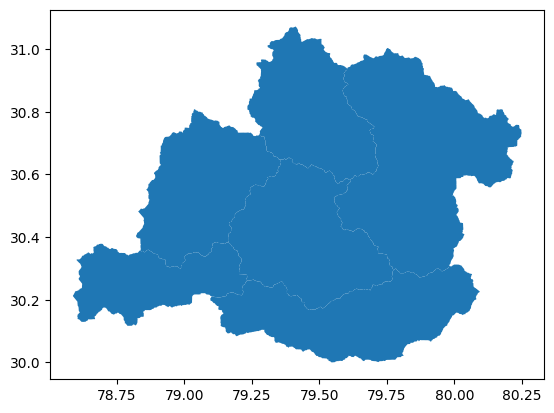

In [16]:
#reading and fitting the shapefile onto the created grid
pth=r'C:\Users\Ankit\Documents\Vedanshi\ML-hands-on\Shapefile_alakananda-20240627T070711Z-001\Shapefile_alakananda\alak_shape_all_84.shp'
shape_file = gpd.read_file(pth)
shape_file.plot()
shape_file.crs

In [17]:
bounding_box=shape_file.total_bounds
bounding_box

array([78.58733532, 30.00003852, 80.24941363, 31.07195327])

In [18]:
new_bounds=[minx,miny,maxx,maxy]
new_bounds-bounding_box

array([-2.4191756 , -2.19663561,  0.9927523 ,  0.32804673])

In [19]:
#manully changing the bounding box to fit the shapefile with approximately +10km on evey side.
minx+=2.32
miny+=2.1034029
maxx-=0.9
maxy-=0.29
new_bounds=[minx,miny,maxx,maxy]
print(new_bounds-bounding_box)
new_bounds

[-0.0991756  -0.09323271  0.0927523   0.03804673]


[78.48815971828309, 29.90680580481834, 80.34216592787854, 31.110000000000003]

The resolution change is not exact.


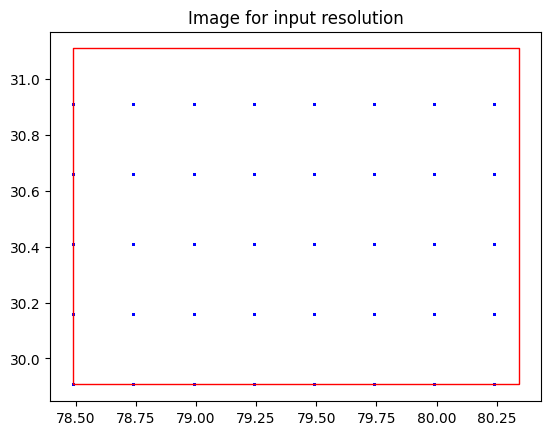

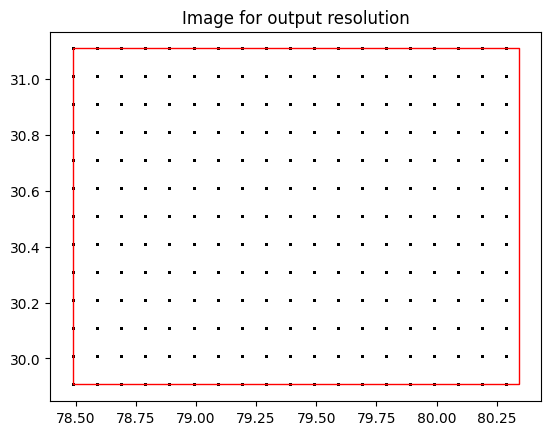

In [20]:
if __name__ == "__main__":
    xc_inp,yc_inp,xc_out,yc_out,grids=res_change(minx, miny, maxx, maxy, input_res=0.25, output_res=0.1)

In [21]:
grid=[]
for cell in grids:
    polygon = Polygon(list(zip(cell['X'], cell['Y'])))
    grid.append(polygon)

grid_gdf = gpd.GeoDataFrame({'geometry': grid}, crs=shape_file.crs)
grid_gdf = gpd.GeoDataFrame({'geometry': grid}, crs=shape_file.crs)

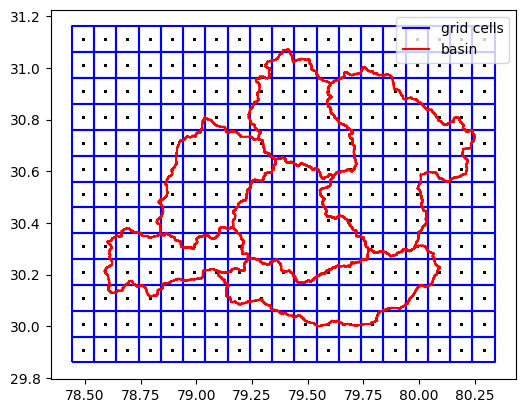

In [22]:
fig, ax = plt.subplots()
ax.scatter(xc_out, yc_out, s=1, color='black')
grid_gdf.boundary.plot(ax=ax, color='blue', label='grid cells')
shape_file.boundary.plot(ax=ax, color='red',label='basin')
plt.legend()
plt.show()

## Loading the data and performing the interpolation at the desired resolution.

In [1]:
#importing the required libraries
import xarray as xr

In [2]:
ds = xr.open_dataset(r'C:\Users\Ankit\Documents\Vedanshi\nc_merged\study_region.nc')
ds

<xarray.Dataset> Size: 3MB
Dimensions:        (time: 14975, lon: 7, nv: 2, lat: 4)
Coordinates:
  * time           (time) datetime64[ns] 120kB 1983-01-01 ... 2023-12-31
  * lat            (lat) float32 16B 30.88 30.62 30.38 30.12
  * lon            (lon) float32 28B 78.62 78.88 79.12 79.38 79.62 79.88 80.12
Dimensions without coordinates: nv
Data variables:
    lon_bnds       (time, lon, nv) float32 839kB ...
    lat_bnds       (time, lat, nv) float32 479kB ...
    precipitation  (time, lon, lat) float32 2MB ...
Attributes: (12/37)
    datetime:                   1983-01-01
    Conventions:                CF-1.6
    title:                      NOAA Climate Data Record (CDR) of Precipitati...
    comment:                    Daily PERSIANN-CDR precipitation estimates fo...
    source:                     GRIDSAT-B1.1983.01.01.00.v02r01.nc,GRIDSAT-B1...
    Metadata_Conventions:       CF-1.6,Unidata Dataset Discovery v1.0, NOAA C...
    ...                         ...
    contributor_role:           PrincipalInvestigator, Professor, Author, Author
    cdr_program:                NOAA Climate Data Record Program
    cdr_variable:               precipitation
    metadata_link:              gov.noaa.ncdc:C00854
    product_version:            v01r01
    spatial_resolution:         0.25 degrees